In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.externals import joblib
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
import gc
import json
from decimal import *

import seaborn as sns; sns.set()
    
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-preproc/__results__.html
/kaggle/input/data-science-bowl-preproc/custom.css
/kaggle/input/data-science-bowl-preproc/reduce_train.csv
/kaggle/input/data-science-bowl-preproc/__notebook__.ipynb
/kaggle/input/data-science-bowl-preproc/features.npy
/kaggle/input/data-science-bowl-preproc/reduce_test.csv
/kaggle/input/data-science-bowl-preproc/__output__.json
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/memory-efficient-faster-way-to-extract-json-data/test_df_json_expanded_4_features.feather
/kaggle/input/memory-efficient-faster-way-to-extract-json-data/__results__.html
/kaggle/input/memory-efficient-faster-way-to-extract-json-data/custom.css
/kaggle/input/memory-efficient-faster-way-to-extract-json-data/__notebook__.ipynb
/kaggle/input/memo

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [3]:
CODE_FIRST_RUN = False

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
    list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index)\
                         .union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            
            features['session_world'] = session['world'].iloc[0]
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [7]:
def get_compiled_data(data,test_set=False,total=17000):
    compiled_data = []
#     for i, (ins_id, user_sample) in tqdm(enumerate(data.groupby('installation_id', sort = False)), total = total):
    for ins_id, user_sample in tqdm(data.groupby('installation_id', sort = False), total = total):
        
        proc_data = get_data(user_sample, test_set = test_set)
        #for test set, proc_data will be dataframe and for train, it will be list type
        if test_set:
            compiled_data.append(proc_data)
        else:
            compiled_data += proc_data
        
    reduce_data = pd.DataFrame(compiled_data)
    categoricals = ['session_title']
    reduce_data.columns = reduce_data.columns.map(str)
    return reduce_data, categoricals


In [8]:
def run_lgb(params, reduce_train, usefull_features,
            decay_factor = None,target = 'accuracy_group',cust_eval=True,
            is_fold_feats=False,
            sel_fold=None,
            n_splits=10,
            fold_type='groupkfold',
           num_boost_round=100000,early_stopping_rounds = 100,verbose_eval = 100):
    
    cur_features= usefull_features.copy()
    cur_params = params.copy()
    
    feature_importance_df = pd.DataFrame()
    if not is_fold_feats:
        feature_importance_df["Feature"] = cur_features
        feature_importance_df["split"] = 0  
        feature_importance_df["gain"] = 0  
    
    
    oof_pred = np.zeros((reduce_train.shape[0], 1))
    coefficients = np.zeros((n_splits, 3))

    if fold_type=='groupkfold':
        print('Using GroupKFold')
        kf = GroupKFold(n_splits=n_splits)
        fold_data = kf.split(reduce_train, reduce_train[target],reduce_train['installation_id'])
    else:
        print('Using StratifiedKFold')
        kf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 42)
        fold_data = kf.split(reduce_train, reduce_train[target])
    
    val_scores = []; iterations=[]; models =[]
    for fold, (tr_ind, val_ind) in enumerate(fold_data):
        
        if sel_fold is not None:
            if sel_fold != fold:
                continue
        
        if is_fold_feats:
            cur_features = usefull_features[fold].copy()
            cur_params = params[fold].copy()
            print('current fold feature size:',len(cur_features))
        
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[cur_features].iloc[tr_ind], reduce_train[cur_features].iloc[val_ind]
        y_train, y_val = reduce_train[target].iloc[tr_ind], reduce_train[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

         
        if  decay_factor is None:
            callbacks = None
        else:
            lr  = float(cur_params['learning_rate'])
            callbacks=[lgb.reset_parameter(learning_rate = lambda current_round: lr * (decay_factor**current_round))]
        
        if cust_eval:
            feval = lgb_qwk
        else:
            feval = None
        model = lgb.train(cur_params, train_set, num_boost_round = num_boost_round, 
                          early_stopping_rounds = early_stopping_rounds, 
                          keep_training_booster=True,
                          feval = feval,
                          valid_sets=[train_set, val_set], 
                          verbose_eval = verbose_eval,
                          callbacks=callbacks
                         )
        models += [model]
        
        if not is_fold_feats:
            if hasattr(model, 'feature_importance'):
                feature_importance_df["split"] += model.feature_importance() / n_splits       
                feature_importance_df["gain"] += model.feature_importance(importance_type='gain') / n_splits       
        
        
        val_pred = model.predict(x_val,num_iteration=model.best_iteration)
#         val_pred = model._Booster__inner_predict(data_idx=1)
        
        #Optimize predictions
#         optR = OptimizedRounder()
#         optR.fit(val_pred, y_val.values)
#         coefficients[fold,:] = optR.coefficients()
#         valid_opt = optR.predict(val_pred, coefficients[fold,:])

        valid_opt = get_pred_labels_fixed_coeff(val_pred)
        val_score = qwk(y_val, valid_opt)
        print('Val OPT QWK Score: ',val_score)
        
#         print("Valid Counts = ", Counter(y_val.values))
#         print("Predicted Counts = ", Counter(valid_opt))
        
#         val_score = cohen_kappa_score(y_val, np.argmax(val_pred, axis = 1), weights = 'quadratic')
#         print('Val Cohen Kappa Score: ',val_score)
        
        oof_pred[val_ind] = val_pred.reshape(-1, 1)
        val_scores +=[val_score]
        
    print('val cohen kappa scores:',val_scores)

    oof_pred_expanded = np.array([item for sublist in oof_pred for item in sublist])
    oof_opt = get_pred_labels_fixed_coeff(oof_pred_expanded)
    loss_score = cohen_kappa_score(reduce_train[target], oof_opt, weights = 'quadratic')
    print('OOF OPT cohen kappa score is: ', loss_score)
    
    print("Mean Score: {}. Std Dev: {}. Mean Coeff: {}".format(np.mean(val_scores), 
                                                               np.std(val_scores), 
                                                               np.mean(coefficients, axis=0)))

    
    return oof_pred, models, feature_importance_df

In [9]:
from collections import Counter
from sklearn import linear_model
from functools import partial
from sklearn import metrics
import json
import scipy as sp
from sklearn.base import BaseEstimator, TransformerMixin
from numba import jit

In [10]:
# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def get_pred_labels_fixed_coeff(y_pred):
    
    y_labels = y_pred.copy()
    
    y_labels[y_labels <= 1.12232214] = 0
    y_labels[np.where(np.logical_and(y_labels > 1.12232214, y_labels <= 1.73925866))] = 1
    y_labels[np.where(np.logical_and(y_labels > 1.73925866, y_labels <= 2.22506454))] = 2
    y_labels[y_labels > 2.22506454] = 3
    
    return y_labels

def lgb_qwk(y_pred, train_data):
    
    labels = train_data.get_label()
    
    y_pred = get_pred_labels_fixed_coeff(y_pred)
    
    score = qwk(labels, y_pred)
    
    return 'cappa', score, True

def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


# @jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [11]:
# improved
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -qwk(y, preds)
#         return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [12]:
# %%time
# # read data
# train, test, train_labels, specs, sample_submission = read_data()
# # get usefull dict with maping encode
# train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

In [13]:
# #read json columns
# path = "/kaggle/input/memory-efficient-faster-way-to-extract-json-data/"
# train_json_expanded = pd.read_feather(path+'train_df_json_expanded_4_features.feather',
#                                   columns =['round','level','misses','correct'])
# train_json_expanded.info()

In [14]:
# train = train.merge(train_json_expanded, left_index=True, right_index=True)
# print(train.shape)
# train.head()

In [15]:
# #read json columns
# path = "/kaggle/input/memory-efficient-faster-way-to-extract-json-data/"
# test_json_expanded = pd.read_feather(path+'test_df_json_expanded_4_features.feather',
#                                   columns =['round','level','misses','correct'])
# test_json_expanded.info()

# test = test.merge(test_json_expanded, left_index=True, right_index=True)
# print(test.shape)
# test.head()

In [16]:
# test_json_expanded[test_json_expanded['correct']==0].head(10)

In [17]:
# train.loc[train['level']==-1,'level']=np.nan
# train.loc[train['round']==-1,'round']=np.nan
# train.loc[train['misses']==-1,'misses']=np.nan
# train.loc[train['correct']==-1,'correct']=np.nan

In [18]:
# del test; gc.collect()

In [19]:
train_copy = None

In [20]:
if CODE_FIRST_RUN:
    if train_copy is None:
        train_copy = train.copy()
    else:
        train  = train_copy.copy()
    sample_ids_train = train['installation_id'].unique()[0:50]
    train = train[train['installation_id'].isin(sample_ids_train)]
    print(train.shape)
    n_splits= 3
    num_boost_round=10
else:
    n_splits= 5
    num_boost_round=10000

In [21]:
# install_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
# train = pd.merge(train, install_id, on="installation_id", how="inner")
# print(install_id.shape)
# print(train.shape)

In [22]:
# %%time
# # tranform function to get the compiled train set
# reduce_data, categoricals = get_compiled_data(train,total=len(install_id))

In [23]:
# del train
# gc.collect()

In [24]:
# #Factors of classes
# class_factors = train_labels['accuracy_group'].value_counts(normalize=True).sort_index().values
# print(class_factors)

In [25]:
%%time
# function that creates more features
def preprocess(reduce_data,test_set=False):
    for df in [reduce_data]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        event_code_cols = [2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]
        event_code_cols= [str(i) for i in event_code_cols]
        
        df['sum_event_code_count'] = df[event_code_cols].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
     
    features = None
    if not test_set:
        features = reduce_data.columns
#         features = reduce_data.loc[(reduce_data.sum(axis=1) != 0), (reduce_data.sum(axis=0) != 0)].columns # delete useless columns
        features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_data, features

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs


In [26]:
# %%time
# # call feature engineering function
# reduce_data, features = preprocess(reduce_data)

In [27]:
%%time
#read json columns
path = "/kaggle/input/data-science-bowl-preproc/"
reduce_data = pd.read_csv(path+'reduce_train.csv',index_col=0)
reduce_test = pd.read_csv(path+'reduce_test.csv',index_col =0)

CPU times: user 3.96 s, sys: 420 ms, total: 4.38 s
Wall time: 4.43 s


In [28]:
z_col=[]
for col in reduce_data.columns:
    if (reduce_data[col].nunique()<=1):
        z_col +=[col]
        
print(len(z_col))
print(z_col)

z_col_test=[]
for col in reduce_test.columns:
    if (reduce_test[col].nunique()<=1):
        z_col_test +=[col]
        
print(len(z_col_test))
print(z_col_test)
z_col_all = set(z_col_test).union(set(z_col))
print(len(z_col_all))
print(z_col_all)

12
['ev_id_003cd2ee', 'ev_id_17ca3959', 'ev_id_4074bac2', 'ev_id_5dc079d8', 'ev_id_a8cc6fec', 'ev_id_dcb1663e', 'titleevcode_Air Show_4080', 'titleevcode_Bottle Filler (Activity)_2010', 'titleevcode_Crystals Rule_2010', 'titleevcode_Pan Balance_2010', 'titleevcode_Sandcastle Builder (Activity)_2010', 'titleevcode_Scrub-A-Dub_4080']
42
['ev_id_003cd2ee', 'ev_id_01ca3a3c', 'ev_id_0ce40006', 'ev_id_119b5b02', 'ev_id_13f56524', 'ev_id_17ca3959', 'ev_id_1b54d27f', 'ev_id_29a42aea', 'ev_id_2ec694de', 'ev_id_4074bac2', 'ev_id_5dc079d8', 'ev_id_611485c5', 'ev_id_7fd1ac25', 'ev_id_a8cc6fec', 'ev_id_ab4ec3a4', 'ev_id_bfc77bd6', 'ev_id_dcb1663e', 'ev_id_e4d32835', 'ev_id_ecc6157f', 'titleevcode_Air Show_4080', 'titleevcode_Bottle Filler (Activity)_2010', 'titleevcode_Bubble Bath_4080', 'titleevcode_Bug Measurer (Activity)_4080', 'titleevcode_Cart Balancer (Assessment)_4080', 'titleevcode_Chest Sorter (Assessment)_4080', 'titleevcode_Crystals Rule_2010', 'titleevcode_Dino Dive_4080', 'titleevcode_

In [29]:
# features = reduce_data.loc[(reduce_data.sum(axis=1) != 0), (reduce_data.sum(axis=0) != 0)].columns # delete useless columns
titleevcode_cols = [col for col in reduce_data.columns if 'titleevcode_' in col]
print(len(titleevcode_cols))
features = reduce_data.columns
features = [x for x in features if (x not in ['accuracy_group','game_session' ,\
                                             'installation_id']) and (x not in z_col_all)
                                               and (x not in titleevcode_cols)] 
print(len(features))

403
478


In [30]:
# features = reduce_data.columns
# features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
# print(len(features))

In [31]:
# exclude_cols = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']
# features = [col for col in reduce_data.columns if col not in exclude_cols]
# print(len(features))

In [32]:
features_ref = ['Clip', 'Activity', 'Assessment', 'Game', 'acc_Mushroom Sorter (Assessment)', 'acc_Chest Sorter (Assessment)', 'acc_Cart Balancer (Assessment)', 'acc_Bird Measurer (Assessment)', 'acc_Cauldron Filler (Assessment)', 2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 2040, 4090, 4220, 4095, '763fc34e', 'beb0a7b9', '19967db1', 'c952eb01', '6f445b57', '7423acbc', '86c924c4', 'e57dd7af', '3b2048ee', '1c178d24', 'c7fe2a55', '3ccd3f02', '65abac75', '37ee8496', '0413e89d', '532a2afb', 'e5c9df6f', 'ec138c1c', '1340b8d7', '7cf1bc53', 'fbaf3456', '76babcde', 'd38c2fd7', '1f19558b', '30614231', '51311d7a', '5f0eb72c', '1af8be29', '73757a5e', 'daac11b0', '3393b68b', '99ea62f3', '4c2ec19f', '0db6d71d', '6088b756', '9d29771f', '7d093bf9', 'dcb55a27', '47026d5f', '6f4adc4b', '5de79a6a', '598f4598', '06372577', 'c58186bf', '5e109ec3', 'b80e5e84', '5b49460a', '7961e599', 'e9c52111', '63f13dd7', '1375ccb7', '93b353f2', 'cb1178ad', '6aeafed4', '08ff79ad', '47efca07', '38074c54', '7525289a', '02a42007', '71e712d8', 'd02b7a8e', '5e812b27', '93edfe2e', 'a1192f43', '1996c610', '2ec694de', '3bb91dda', '37c53127', '070a5291', 'e04fb33d', '5be391b5', '3ee399c3', '363c86c9', 'd3f1e122', 'b7530680', '3babcb9b', '792530f8', '4901243f', 'cfbd47c8', '4ef8cdd3', '3bf1cf26', '0086365d', '262136f4', '119b5b02', '2dc29e21', '0a08139c', '0330ab6a', '9de5e594', '56cd3b43', '55115cbd', '160654fd', 'bfc77bd6', '0d18d96c', '86ba578b', '51102b85', 'f50fc6c1', '77c76bc5', 'e5734469', '461eace6', '2fb91ec1', '08fd73f3', 'c74f40cd', '4bb2f698', '6043a2b4', 'a7640a16', '895865f3', '587b5989', 'c54cf6c5', 'bd612267', '5dc079d8', '565a3990', '13f56524', 'ca11f653', '15f99afc', 'f7e47413', '83c6c409', '30df3273', '736f9581', 'cc5087a3', 'f5b8c21a', '49ed92e9', 'c7128948', 'cf82af56', 'd06f75b5', 'e080a381', '15a43e5b', 'ad148f58', 'a44b10dc', '67439901', '1cf54632', '923afab1', '4d911100', '90efca10', 'd51b1749', '795e4a37', '828e68f9', 'e4d32835', 'e720d930', '37937459', '1bb5fbdb', 'f806dc10', 'f32856e4', '74e5f8a7', '5a848010', '8d748b58', '5e3ea25a', '8b757ab8', '8ac7cce4', '28520915', '28ed704e', 'b2e5b0f1', '5c3d2b2f', '31973d56', '9b4001e4', 'b1d5101d', 'f56e0afc', 'f6947f54', 'd9c005dd', '222660ff', '3dfd4aa4', 'e37a2b78', '6c517a88', '29bdd9ba', '77261ab5', 'd2278a3b', '9e34ea74', '1325467d', 'ea296733', '9b23e8ee', 'bb3e370b', '9d4e7b25', '7da34a02', 'a5e9da97', '77ead60d', '7040c096', 'cf7638f3', '499edb7c', '6c930e6e', '90ea0bac', '37db1c2f', '2a512369', 'a76029ee', 'c51d8688', '16dffff1', '00c73085', 'a8cc6fec', '2b9272f4', '709b1251', '05ad839b', '3afde5dd', '29a42aea', '6bf9e3e1', '5c2f29ca', 'c0415e5c', 'df4fe8b6', 'e4f1efe6', '8d84fa81', 'bbfe0445', 'b88f38da', '832735e1', '5f5b2617', 'dcaede90', 'a6d66e51', 'f3cd5473', 'b2dba42b', '4074bac2', '6f4bd64e', '4b5efe37', '44cb4907', 'a16a373e', 'd2e9262e', 'e7561dd2', '26a5a3dd', '5859dfb6', '2c4e6db0', 'd3640339', 'a1e4395d', '58a0de5c', 'ecaab346', 'f54238ee', '1cc7cfca', '9ed8f6da', '884228c8', 'a0faea5d', 'd2659ab4', 'b5053438', '3d8c61b0', '8fee50e2', '3d0b9317', '04df9b66', '857f21c0', '7ec0c298', '84538528', '2b058fe3', '0d1da71f', '56bcd38d', '3afb49e6', 'a592d54e', '7372e1a5', '3dcdda7f', '9e4c8c7b', '2a444e03', '84b0e0c8', 'b012cd7f', 'abc5811c', '91561152', 'ecc36b7f', 'eb2c19cd', '6cf7d25c', 'ecc6157f', 'fcfdffb6', '7fd1ac25', '4a4c3d21', 'd122731b', 'd88e8f25', '731c0cbe', '26fd2d99', '6077cc36', '3edf6747', '907a054b', '4e5fc6f5', '48349b14', 'bcceccc6', 'e7e44842', 'f28c589a', '022b4259', 'd3268efa', 'bc8f2793', 'a5be6304', 'e64e2cfd', '8af75982', 'c6971acf', 'c1cac9a2', 'a8efe47b', '0ce40006', '45d01abe', 'f71c4741', '1beb320a', 'ad2fc29c', '2230fab4', '1575e76c', '9e6b7fb5', '88d4a5be', '85d1b0de', '56817e2b', 'f93fc684', '9ce586dd', '27253bdc', 'e3ff61fb', 'bdf49a58', 'd88ca108', '7dfe6d8a', '9b01374f', 'a8a78786', '804ee27f', '29f54413', 'e694a35b', 'c189aaf2', '53c6e11a', '47f43a44', 'fd20ea40', '28f975ea', '9c5ef70c', 'd185d3ea', '3d63345e', '003cd2ee', 'a8876db3', '14de4c5d', '87d743c1', '3a4be871', '5d042115', 'acf5c23f', '155f62a4', '89aace00', '7d5c30a2', 'a29c5338', '8f094001', '9ee1c98c', '46cd75b4', 'db02c830', '16667cc5', '69fdac0a', '17ca3959', '756e5507', 'dcb1663e', 'ab4ec3a4', 'ab3136ba', '71fe8f75', '250513af', '363d3849', '65a38bf7', '90d848e0', '5154fc30', '3bb91ced', 'df4940d3', '9554a50b', 'bd701df8', '36fa3ebe', '3bfd1a65', 'e79f3763', '4a09ace1', '28a4eb9a', '01ca3a3c', '85de926c', '2dcad279', '46b50ba8', '5348fd84', 'a52b92d5', '4d6737eb', '3323d7e9', '6d90d394', '6f8106d9', '611485c5', '7ad3efc6', '15ba1109', '562cec5f', 'b74258a0', '25fa8af4', '3ddc79c3', '99abe2bb', 'ac92046e', '7f0836bf', 'a1bbe385', 'cb6010f8', 'b120f2ac', '92687c59', 'c277e121', 'de26c3a6', 'c2baf0bd', '17113b36', '7ab78247', 'cdd22e43', 'ea321fb1', '1b54d27f', 'd45ed6a1', '8d7e386c', '15eb4a7d', '67aa2ada', '33505eae', '5290eab1', '392e14df', 'b7dc8128', 'c7f7f0e1', 'a2df0760', 'Balancing Act', 'Chicken Balancer (Activity)', 'Fireworks (Activity)', 'Crystal Caves - Level 1', 'Slop Problem', 'Cart Balancer (Assessment)', 'Scrub-A-Dub', 'Welcome to Lost Lagoon!', 'Magma Peak - Level 1', 'Crystal Caves - Level 2', 'Chow Time', 'Honey Cake', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Mushroom Sorter (Assessment)', 'Heavy, Heavier, Heaviest', 'Tree Top City - Level 1', 'Dino Dive', 'Pan Balance', 'Crystals Rule', '12 Monkeys', 'Air Show', 'Rulers', 'Treasure Map', 'Tree Top City - Level 2', 'Ordering Spheres', 'Flower Waterer (Activity)', 'Chest Sorter (Assessment)', 'Sandcastle Builder (Activity)', "Pirate's Tale", 'Dino Drink', 'Magma Peak - Level 2', 'Bottle Filler (Activity)', 'Lifting Heavy Things', 'Happy Camel', 'All Star Sorting', 'Bird Measurer (Assessment)', 'Bubble Bath', 'Leaf Leader', 'Crystal Caves - Level 3', 'Egg Dropper (Activity)', 'Costume Box', 'Bug Measurer (Activity)', 'Cauldron Filler (Assessment)', 'Crystals Rule_4050', 'Leaf Leader_3110', 'Flower Waterer (Activity)_4022', 'Cart Balancer (Assessment)_2000', 'Chow Time_4030', 'Mushroom Sorter (Assessment)_4030', 'Scrub-A-Dub_2083', 'Bottle Filler (Activity)_4030', 'Egg Dropper (Activity)_4090', 'Dino Drink_3110', 'Scrub-A-Dub_4080', 'Watering Hole (Activity)_3010', 'Cauldron Filler (Assessment)_2000', 'Mushroom Sorter (Assessment)_4080', 'Chest Sorter (Assessment)_2020', 'Fireworks (Activity)_3010', 'Scrub-A-Dub_2050', 'Pan Balance_2010', 'Air Show_2070', 'Bug Measurer (Activity)_2000', 'Crystal Caves - Level 2_2000', 'Leaf Leader_3020', 'Bottle Filler (Activity)_3010', 'Crystals Rule_2000', 'Bottle Filler (Activity)_4035', 'Cauldron Filler (Assessment)_3010', 'Watering Hole (Activity)_4020', 'Bird Measurer (Assessment)_4100', 'Fireworks (Activity)_2000', 'All Star Sorting_2030', 'Cauldron Filler (Assessment)_4070', 'Mushroom Sorter (Assessment)_2035', 'Air Show_3121', 'Bubble Bath_4045', 'Bubble Bath_4235', 'Bubble Bath_2035', 'Flower Waterer (Activity)_4080', 'Leaf Leader_4095', 'Leaf Leader_4090', 'Pan Balance_3010', 'Happy Camel_4030', 'Leaf Leader_2070', 'All Star Sorting_4080', 'Magma Peak - Level 2_2000', 'Bug Measurer (Activity)_4030', 'Welcome to Lost Lagoon!_2000', 'Cart Balancer (Assessment)_3010', 'Dino Drink_2000', 'Chest Sorter (Assessment)_2010', 'Sandcastle Builder (Activity)_4035', 'Scrub-A-Dub_3120', 'Mushroom Sorter (Assessment)_3010', 'Scrub-A-Dub_4010', 'Mushroom Sorter (Assessment)_2010', 'Dino Drink_2075', 'Bottle Filler (Activity)_2030', 'Bird Measurer (Assessment)_4080', 'Bird Measurer (Assessment)_4110', 'Honey Cake_2000', 'Pan Balance_4020', 'Chicken Balancer (Activity)_4090', 'Bubble Bath_3110', 'Tree Top City - Level 2_2000', 'Happy Camel_4090', 'Pan Balance_3020', 'Bubble Bath_4095', 'Bubble Bath_4040', 'Dino Dive_3020', 'Dino Dive_4010', 'Bottle Filler (Activity)_2000', 'Pan Balance_4080', 'Sandcastle Builder (Activity)_3110', 'Cauldron Filler (Assessment)_3110', 'Air Show_3010', 'Cauldron Filler (Assessment)_2030', 'Air Show_2000', 'Cauldron Filler (Assessment)_4040', 'Bubble Bath_2000', 'Bug Measurer (Activity)_4080', 'Cauldron Filler (Assessment)_3120', 'Sandcastle Builder (Activity)_4030', 'Chow Time_4080', 'Bird Measurer (Assessment)_3121', 'Bottle Filler (Activity)_4020', 'Air Show_2030', 'Leaf Leader_4070', 'Leaf Leader_3120', 'Crystals Rule_3020', 'Cart Balancer (Assessment)_3020', 'Fireworks (Activity)_4090', 'Dino Dive_3120', 'Happy Camel_4010', 'Dino Dive_4070', 'Chicken Balancer (Activity)_4020', 'All Star Sorting_4090', 'Fireworks (Activity)_3110', 'Bird Measurer (Assessment)_3110', 'Sandcastle Builder (Activity)_2000', 'Chest Sorter (Assessment)_3021', 'Tree Top City - Level 3_2000', 'Bird Measurer (Assessment)_2010', 'All Star Sorting_3010', 'Dino Drink_4020', 'Fireworks (Activity)_4080', 'Dino Dive_3021', 'Cauldron Filler (Assessment)_3021', 'Air Show_4090', 'Chest Sorter (Assessment)_4025', 'Bug Measurer (Activity)_3110', 'Crystals Rule_3021', 'Fireworks (Activity)_4020', 'Cauldron Filler (Assessment)_4080', 'Balancing Act_2000', 'Dino Drink_2060', 'Scrub-A-Dub_4020', 'Chow Time_3010', 'Mushroom Sorter (Assessment)_4025', 'Bird Measurer (Assessment)_4040', 'All Star Sorting_3120', 'All Star Sorting_3110', 'Bird Measurer (Assessment)_2000', 'Bird Measurer (Assessment)_4025', 'Cart Balancer (Assessment)_3121', 'Chest Sorter (Assessment)_4090', 'Egg Dropper (Activity)_2020', 'Bubble Bath_3121', 'Chow Time_4010', 'Air Show_3020', 'Happy Camel_4040', 'Chicken Balancer (Activity)_3010', 'Costume Box_2000', 'Chicken Balancer (Activity)_4080', 'Leaf Leader_2060', 'Flower Waterer (Activity)_3110', 'Scrub-A-Dub_2040', 'Watering Hole (Activity)_4090', 'Dino Drink_4031', 'Happy Camel_4045', 'Watering Hole (Activity)_3110', 'Chest Sorter (Assessment)_4070', 'Bubble Bath_4090', 'Crystals Rule_2030', 'Happy Camel_4020', 'Cauldron Filler (Assessment)_3121', 'Chest Sorter (Assessment)_4100', 
                'Bottle Filler (Activity)_4090', 'Bird Measurer (Assessment)_3120', 'Mushroom Sorter (Assessment)_4100', 'Chest Sorter (Assessment)_4040', 'Chest Sorter (Assessment)_4035', 'Happy Camel_2080', 'Happy Camel_4080', 'Cart Balancer (Assessment)_2010', 'Bubble Bath_4230', 'Dino Drink_4030', 'Bird Measurer (Assessment)_2020', 'Sandcastle Builder (Activity)_4090', 'Dino Dive_2070', 'Dino Drink_3010', 'Chow Time_2030', 'Sandcastle Builder (Activity)_3010', 'Bird Measurer (Assessment)_3021', 'Sandcastle Builder (Activity)_4020', 'Chest Sorter (Assessment)_2030', 'All Star Sorting_4010', 'Chow Time_4095', 'Pan Balance_3021', 'Dino Dive_4080', 'Chicken Balancer (Activity)_3110', 'Happy Camel_3121', 'Leaf Leader_4080', 'All Star Sorting_2020', 'Happy Camel_2000', 'Air Show_3110', 'Air Show_4100', 'Happy Camel_4095', 'Bubble Bath_4220', 'Air Show_4010', 'Chow Time_2020', 'Air Show_4020', 'Flower Waterer (Activity)_4070', 'Bubble Bath_4010', 'Cart Balancer (Assessment)_4100', 'Air Show_4080', 'Cart Balancer (Assessment)_3021', 'Scrub-A-Dub_2030', 'Mushroom Sorter (Assessment)_3020', 'Chow Time_4090', 'Scrub-A-Dub_4090', 'Cart Balancer (Assessment)_3120', 'Bird Measurer (Assessment)_3020', 'Scrub-A-Dub_4070', 'Flower Waterer (Activity)_4030', 'Pan Balance_4025', 'Happy Camel_2020', 'Air Show_3021', 'Happy Camel_4070', 'Cart Balancer (Assessment)_3110', 'Rulers_2000', 'Bubble Bath_2020', 'Dino Dive_2020', 'Crystal Caves - Level 3_2000', 'Cauldron Filler (Assessment)_4020', 'Chest Sorter (Assessment)_4030', 'Dino Dive_3010', 'Chow Time_2000', 'Mushroom Sorter (Assessment)_3121', 'Happy Camel_2081', 'Egg Dropper (Activity)_4020', 'All Star Sorting_3121', 'Air Show_2060', 'Bubble Bath_4020', 'Happy Camel_3020', 'Leaf Leader_2020', 'Cart Balancer (Assessment)_4020', 'Pan Balance_2020', 'Cauldron Filler (Assessment)_3020', 'Pan Balance_4090', 'Bubble Bath_3020', 'All Star Sorting_4095', 'Bubble Bath_2030', 'Crystals Rule_3121', 'All Star Sorting_4035', 'Cauldron Filler (Assessment)_2010', 'Crystals Rule_2010', 'Leaf Leader_4020', 'Mushroom Sorter (Assessment)_4040', 'Crystals Rule_4070', 'Flower Waterer (Activity)_4025', 'Cauldron Filler (Assessment)_4090', 'Dino Dive_4090', 'Leaf Leader_2075', 'Bubble Bath_4080', 'Happy Camel_2083', 'Dino Dive_2030', 'Slop Problem_2000', 'Egg Dropper (Activity)_3010', 'Chow Time_3110', 'Bubble Bath_2083', 'Tree Top City - Level 1_2000', 'Bird Measurer (Assessment)_3010', 'Cauldron Filler (Assessment)_2020', 'Mushroom Sorter (Assessment)_4070', 'Dino Drink_4090', 'Cauldron Filler (Assessment)_4035', 'Crystals Rule_3120', 'Scrub-A-Dub_3010', 'Cart Balancer (Assessment)_4035', 'Dino Dive_4020', 'Cart Balancer (Assessment)_4030', 'Pan Balance_4030', 'Chow Time_3121', 'Dino Drink_4070', 'Crystals Rule_4020', 'Dino Drink_3121', 'Chicken Balancer (Activity)_2000', 'Crystal Caves - Level 1_2000', 'Mushroom Sorter (Assessment)_4020', 'Bug Measurer (Activity)_4090', 'Dino Drink_3120', 'Watering Hole (Activity)_2010', 'Chicken Balancer (Activity)_4035', "Pirate's Tale_2000", 'Bug Measurer (Activity)_4025', 'Cart Balancer (Assessment)_4070', 'All Star Sorting_4030', 'Mushroom Sorter (Assessment)_4090', 'Dino Drink_4080', 'Air Show_2020', 'Leaf Leader_3021', 'Bird Measurer (Assessment)_2030', 'Chicken Balancer (Activity)_4030', 'Chest Sorter (Assessment)_3121', 'Leaf Leader_4010', 'Cart Balancer (Assessment)_2030', 'Bottle Filler (Activity)_3110', 'Air Show_4070', 'Bubble Bath_2080', 'Watering Hole (Activity)_5010', 'Scrub-A-Dub_2020', 'All Star Sorting_4020', 'Chicken Balancer (Activity)_4022', 'Bird Measurer (Assessment)_4035', 'Egg Dropper (Activity)_4025', 'Leaf Leader_3121', 'Scrub-A-Dub_3021', 'Bird Measurer (Assessment)_4090', 'Leaf Leader_2030', 'Leaf Leader_2000', 'Bug Measurer (Activity)_4070', 'Ordering Spheres_2000', 'Bottle Filler (Activity)_2010', 'Cauldron Filler (Assessment)_4030', 'Leaf Leader_3010', 'All Star Sorting_4070', 'Scrub-A-Dub_2000', 'Chow Time_3120', 'Magma Peak - Level 1_2000', 'Bubble Bath_2025', 'Cauldron Filler (Assessment)_4100', 'Scrub-A-Dub_3110', 'Chow Time_4020', '12 Monkeys_2000', 'Flower Waterer (Activity)_2000', 'Cart Balancer (Assessment)_4040', 'Flower Waterer (Activity)_4090', 'Bottle Filler (Activity)_4080', 'Chest Sorter (Assessment)_3010', 'Pan Balance_4035', 'All Star Sorting_2025', 'Crystals Rule_4090', 'Dino Drink_2020', 'Dino Drink_2030', 'Cart Balancer (Assessment)_4080', 'Egg Dropper (Activity)_4080', 'Crystals Rule_3110', 'Sandcastle Builder (Activity)_4021', 'Chest Sorter (Assessment)_3110', 'Chest Sorter (Assessment)_4080', 'Pan Balance_2030', 'Flower Waterer (Activity)_4020', 'Bottle Filler (Activity)_4070', 'Chest Sorter (Assessment)_4020', 'Bubble Bath_3021', 'Happy Camel_3010', 'Air Show_4110', 'Cart Balancer (Assessment)_4090', 'Bubble Bath_3120', 'Mushroom Sorter (Assessment)_2000', 'Mushroom Sorter (Assessment)_2020', 'Scrub-A-Dub_3020', 'Bubble Bath_3010', 'Happy Camel_4035', 'Pan Balance_4100', 'Dino Drink_3021', 'Crystals Rule_3010', 'Dino Dive_3110', 'Happy Camel_3120', 'Pan Balance_3120', 'Sandcastle Builder (Activity)_4070', 'Mushroom Sorter (Assessment)_4035', 'Bird Measurer (Assessment)_4030', 'Happy Camel_3021', 'Heavy, Heavier, Heaviest_2000', 'Pan Balance_3110', 'Egg Dropper (Activity)_4070', 'All Star Sorting_3021', 'Chow Time_4070', 'Happy Camel_2030', 'Scrub-A-Dub_3121', 'Dino Dive_2000', 'Watering Hole (Activity)_4070', 'Chicken Balancer (Activity)_4070', 'Mushroom Sorter (Assessment)_3120', 'Cauldron Filler (Assessment)_4025', 'Pan Balance_3121', 'Air Show_2075', 'Mushroom Sorter (Assessment)_2025', 'Chow Time_4035', 'Bird Measurer (Assessment)_4070', 'Flower Waterer (Activity)_3010', 'Egg Dropper (Activity)_3110', 'Watering Hole (Activity)_4021', 'Chow Time_3020', 'Dino Drink_4010', 'Chest Sorter (Assessment)_2000', 'Air Show_3120', 'Treasure Map_2000', 'Mushroom Sorter (Assessment)_3021', 'Chow Time_3021', 'Scrub-A-Dub_2080', 'Happy Camel_3110', 'Dino Dive_2060', 'Crystals Rule_2020', 'Bubble Bath_4070', 'All Star Sorting_2000', 'Egg Dropper (Activity)_2000', 'Dino Drink_2070', 'Bug Measurer (Activity)_3010', 'Chest Sorter (Assessment)_3120', 'Bug Measurer (Activity)_4035', 'Sandcastle Builder (Activity)_2010', 'Cart Balancer (Assessment)_2020', 'Mushroom Sorter (Assessment)_3110', 'Scrub-A-Dub_2081', 'Fireworks (Activity)_4070', 'Dino Drink_3020', 'Watering Hole (Activity)_5000', 'Pan Balance_4010', 'Pan Balance_4070', 'Watering Hole (Activity)_2000', 'Mushroom Sorter (Assessment)_2030', 'Crystals Rule_4010', 'Dino Dive_3121', 'Chest Sorter (Assessment)_3020', 'Bird Measurer (Assessment)_4020', 'Fireworks (Activity)_4030', 'Bottle Filler (Activity)_2020', 'Pan Balance_2000', 'Lifting Heavy Things_2000', 'Sandcastle Builder (Activity)_4080', 'Watering Hole (Activity)_4025', 'All Star Sorting_3020', 'session_title', 'accumulated_correct_attempts', 'accumulated_uncorrect_attempts', 'duration_mean', 'accumulated_accuracy', 0, 1, 2, 3, 'accumulated_accuracy_group', 'accumulated_actions', 'installation_session_count', 'installation_duration_mean', 'installation_title_nunique', 'sum_event_code_count', 'installation_event_code_count_mean']


In [33]:
features_title_ev_code =['Crystals Rule_4050', 'Leaf Leader_3110', 'Flower Waterer (Activity)_4022', 'Cart Balancer (Assessment)_2000', 'Chow Time_4030', 'Mushroom Sorter (Assessment)_4030', 'Scrub-A-Dub_2083', 'Bottle Filler (Activity)_4030', 'Egg Dropper (Activity)_4090', 'Dino Drink_3110', 'Scrub-A-Dub_4080', 'Watering Hole (Activity)_3010', 'Cauldron Filler (Assessment)_2000', 'Mushroom Sorter (Assessment)_4080', 'Chest Sorter (Assessment)_2020', 'Fireworks (Activity)_3010', 'Scrub-A-Dub_2050', 'Pan Balance_2010', 'Air Show_2070', 'Bug Measurer (Activity)_2000', 'Crystal Caves - Level 2_2000', 'Leaf Leader_3020', 'Bottle Filler (Activity)_3010', 'Crystals Rule_2000', 'Bottle Filler (Activity)_4035', 'Cauldron Filler (Assessment)_3010', 'Watering Hole (Activity)_4020', 'Bird Measurer (Assessment)_4100', 'Fireworks (Activity)_2000', 'All Star Sorting_2030', 'Cauldron Filler (Assessment)_4070', 'Mushroom Sorter (Assessment)_2035', 'Air Show_3121', 'Bubble Bath_4045', 'Bubble Bath_4235', 'Bubble Bath_2035', 'Flower Waterer (Activity)_4080', 'Leaf Leader_4095', 'Leaf Leader_4090', 'Pan Balance_3010', 'Happy Camel_4030', 'Leaf Leader_2070', 'All Star Sorting_4080', 'Magma Peak - Level 2_2000', 'Bug Measurer (Activity)_4030', 'Welcome to Lost Lagoon!_2000', 'Cart Balancer (Assessment)_3010', 'Dino Drink_2000', 'Chest Sorter (Assessment)_2010', 'Sandcastle Builder (Activity)_4035', 'Scrub-A-Dub_3120', 'Mushroom Sorter (Assessment)_3010', 'Scrub-A-Dub_4010', 'Mushroom Sorter (Assessment)_2010', 'Dino Drink_2075', 'Bottle Filler (Activity)_2030', 'Bird Measurer (Assessment)_4080', 'Bird Measurer (Assessment)_4110', 'Honey Cake_2000', 'Pan Balance_4020', 'Chicken Balancer (Activity)_4090', 'Bubble Bath_3110', 'Tree Top City - Level 2_2000', 'Happy Camel_4090', 'Pan Balance_3020', 'Bubble Bath_4095', 'Bubble Bath_4040', 'Dino Dive_3020', 'Dino Dive_4010', 'Bottle Filler (Activity)_2000', 'Pan Balance_4080', 'Sandcastle Builder (Activity)_3110', 'Cauldron Filler (Assessment)_3110', 'Air Show_3010', 'Cauldron Filler (Assessment)_2030', 'Air Show_2000', 'Cauldron Filler (Assessment)_4040', 'Bubble Bath_2000', 'Bug Measurer (Activity)_4080', 'Cauldron Filler (Assessment)_3120', 'Sandcastle Builder (Activity)_4030', 'Chow Time_4080', 'Bird Measurer (Assessment)_3121', 'Bottle Filler (Activity)_4020', 'Air Show_2030', 'Leaf Leader_4070', 'Leaf Leader_3120', 'Crystals Rule_3020', 'Cart Balancer (Assessment)_3020', 'Fireworks (Activity)_4090', 'Dino Dive_3120', 'Happy Camel_4010', 'Dino Dive_4070', 'Chicken Balancer (Activity)_4020', 'All Star Sorting_4090', 'Fireworks (Activity)_3110', 'Bird Measurer (Assessment)_3110', 'Sandcastle Builder (Activity)_2000', 'Chest Sorter (Assessment)_3021', 'Tree Top City - Level 3_2000', 'Bird Measurer (Assessment)_2010', 'All Star Sorting_3010', 'Dino Drink_4020', 'Fireworks (Activity)_4080', 'Dino Dive_3021', 'Cauldron Filler (Assessment)_3021', 'Air Show_4090', 'Chest Sorter (Assessment)_4025', 'Bug Measurer (Activity)_3110', 'Crystals Rule_3021', 'Fireworks (Activity)_4020', 'Cauldron Filler (Assessment)_4080', 'Balancing Act_2000', 'Dino Drink_2060', 'Scrub-A-Dub_4020', 'Chow Time_3010', 'Mushroom Sorter (Assessment)_4025', 'Bird Measurer (Assessment)_4040', 'All Star Sorting_3120', 'All Star Sorting_3110', 'Bird Measurer (Assessment)_2000', 'Bird Measurer (Assessment)_4025', 'Cart Balancer (Assessment)_3121', 'Chest Sorter (Assessment)_4090', 'Egg Dropper (Activity)_2020', 'Bubble Bath_3121', 'Chow Time_4010', 'Air Show_3020', 'Happy Camel_4040', 'Chicken Balancer (Activity)_3010', 'Costume Box_2000', 'Chicken Balancer (Activity)_4080', 'Leaf Leader_2060', 'Flower Waterer (Activity)_3110', 'Scrub-A-Dub_2040', 'Watering Hole (Activity)_4090', 'Dino Drink_4031', 'Happy Camel_4045', 'Watering Hole (Activity)_3110', 'Chest Sorter (Assessment)_4070', 'Bubble Bath_4090', 'Crystals Rule_2030', 'Happy Camel_4020', 'Cauldron Filler (Assessment)_3121', 'Chest Sorter (Assessment)_4100', 
                'Bottle Filler (Activity)_4090', 'Bird Measurer (Assessment)_3120', 'Mushroom Sorter (Assessment)_4100', 'Chest Sorter (Assessment)_4040', 'Chest Sorter (Assessment)_4035', 'Happy Camel_2080', 'Happy Camel_4080', 'Cart Balancer (Assessment)_2010', 'Bubble Bath_4230', 'Dino Drink_4030', 'Bird Measurer (Assessment)_2020', 'Sandcastle Builder (Activity)_4090', 'Dino Dive_2070', 'Dino Drink_3010', 'Chow Time_2030', 'Sandcastle Builder (Activity)_3010', 'Bird Measurer (Assessment)_3021', 'Sandcastle Builder (Activity)_4020', 'Chest Sorter (Assessment)_2030', 'All Star Sorting_4010', 'Chow Time_4095', 'Pan Balance_3021', 'Dino Dive_4080', 'Chicken Balancer (Activity)_3110', 'Happy Camel_3121', 'Leaf Leader_4080', 'All Star Sorting_2020', 'Happy Camel_2000', 'Air Show_3110', 'Air Show_4100', 'Happy Camel_4095', 'Bubble Bath_4220', 'Air Show_4010', 'Chow Time_2020', 'Air Show_4020', 'Flower Waterer (Activity)_4070', 'Bubble Bath_4010', 'Cart Balancer (Assessment)_4100', 'Air Show_4080', 'Cart Balancer (Assessment)_3021', 'Scrub-A-Dub_2030', 'Mushroom Sorter (Assessment)_3020', 'Chow Time_4090', 'Scrub-A-Dub_4090', 'Cart Balancer (Assessment)_3120', 'Bird Measurer (Assessment)_3020', 'Scrub-A-Dub_4070', 'Flower Waterer (Activity)_4030', 'Pan Balance_4025', 'Happy Camel_2020', 'Air Show_3021', 'Happy Camel_4070', 'Cart Balancer (Assessment)_3110', 'Rulers_2000', 'Bubble Bath_2020', 'Dino Dive_2020', 'Crystal Caves - Level 3_2000', 'Cauldron Filler (Assessment)_4020', 'Chest Sorter (Assessment)_4030', 'Dino Dive_3010', 'Chow Time_2000', 'Mushroom Sorter (Assessment)_3121', 'Happy Camel_2081', 'Egg Dropper (Activity)_4020', 'All Star Sorting_3121', 'Air Show_2060', 'Bubble Bath_4020', 'Happy Camel_3020', 'Leaf Leader_2020', 'Cart Balancer (Assessment)_4020', 'Pan Balance_2020', 'Cauldron Filler (Assessment)_3020', 'Pan Balance_4090', 'Bubble Bath_3020', 'All Star Sorting_4095', 'Bubble Bath_2030', 'Crystals Rule_3121', 'All Star Sorting_4035', 'Cauldron Filler (Assessment)_2010', 'Crystals Rule_2010', 'Leaf Leader_4020', 'Mushroom Sorter (Assessment)_4040', 'Crystals Rule_4070', 'Flower Waterer (Activity)_4025', 'Cauldron Filler (Assessment)_4090', 'Dino Dive_4090', 'Leaf Leader_2075', 'Bubble Bath_4080', 'Happy Camel_2083', 'Dino Dive_2030', 'Slop Problem_2000', 'Egg Dropper (Activity)_3010', 'Chow Time_3110', 'Bubble Bath_2083', 'Tree Top City - Level 1_2000', 'Bird Measurer (Assessment)_3010', 'Cauldron Filler (Assessment)_2020', 'Mushroom Sorter (Assessment)_4070', 'Dino Drink_4090', 'Cauldron Filler (Assessment)_4035', 'Crystals Rule_3120', 'Scrub-A-Dub_3010', 'Cart Balancer (Assessment)_4035', 'Dino Dive_4020', 'Cart Balancer (Assessment)_4030', 'Pan Balance_4030', 'Chow Time_3121', 'Dino Drink_4070', 'Crystals Rule_4020', 'Dino Drink_3121', 'Chicken Balancer (Activity)_2000', 'Crystal Caves - Level 1_2000', 'Mushroom Sorter (Assessment)_4020', 'Bug Measurer (Activity)_4090', 'Dino Drink_3120', 'Watering Hole (Activity)_2010', 'Chicken Balancer (Activity)_4035', "Pirate's Tale_2000", 'Bug Measurer (Activity)_4025', 'Cart Balancer (Assessment)_4070', 'All Star Sorting_4030', 'Mushroom Sorter (Assessment)_4090', 'Dino Drink_4080', 'Air Show_2020', 'Leaf Leader_3021', 'Bird Measurer (Assessment)_2030', 'Chicken Balancer (Activity)_4030', 'Chest Sorter (Assessment)_3121', 'Leaf Leader_4010', 'Cart Balancer (Assessment)_2030', 'Bottle Filler (Activity)_3110', 'Air Show_4070', 'Bubble Bath_2080', 'Watering Hole (Activity)_5010', 'Scrub-A-Dub_2020', 'All Star Sorting_4020', 'Chicken Balancer (Activity)_4022', 'Bird Measurer (Assessment)_4035', 'Egg Dropper (Activity)_4025', 'Leaf Leader_3121', 'Scrub-A-Dub_3021', 'Bird Measurer (Assessment)_4090', 'Leaf Leader_2030', 'Leaf Leader_2000', 'Bug Measurer (Activity)_4070', 'Ordering Spheres_2000', 'Bottle Filler (Activity)_2010', 'Cauldron Filler (Assessment)_4030', 'Leaf Leader_3010', 'All Star Sorting_4070', 'Scrub-A-Dub_2000', 'Chow Time_3120', 'Magma Peak - Level 1_2000', 'Bubble Bath_2025', 'Cauldron Filler (Assessment)_4100', 'Scrub-A-Dub_3110', 'Chow Time_4020', '12 Monkeys_2000', 'Flower Waterer (Activity)_2000', 'Cart Balancer (Assessment)_4040', 'Flower Waterer (Activity)_4090', 'Bottle Filler (Activity)_4080', 'Chest Sorter (Assessment)_3010', 'Pan Balance_4035', 'All Star Sorting_2025', 'Crystals Rule_4090', 'Dino Drink_2020', 'Dino Drink_2030', 'Cart Balancer (Assessment)_4080', 'Egg Dropper (Activity)_4080', 'Crystals Rule_3110', 'Sandcastle Builder (Activity)_4021', 'Chest Sorter (Assessment)_3110', 'Chest Sorter (Assessment)_4080', 'Pan Balance_2030', 'Flower Waterer (Activity)_4020', 'Bottle Filler (Activity)_4070', 'Chest Sorter (Assessment)_4020', 'Bubble Bath_3021', 'Happy Camel_3010', 'Air Show_4110', 'Cart Balancer (Assessment)_4090', 'Bubble Bath_3120', 'Mushroom Sorter (Assessment)_2000', 'Mushroom Sorter (Assessment)_2020', 'Scrub-A-Dub_3020', 'Bubble Bath_3010', 'Happy Camel_4035', 'Pan Balance_4100', 'Dino Drink_3021', 'Crystals Rule_3010', 'Dino Dive_3110', 'Happy Camel_3120', 'Pan Balance_3120', 'Sandcastle Builder (Activity)_4070', 'Mushroom Sorter (Assessment)_4035', 'Bird Measurer (Assessment)_4030', 'Happy Camel_3021', 'Heavy, Heavier, Heaviest_2000', 'Pan Balance_3110', 'Egg Dropper (Activity)_4070', 'All Star Sorting_3021', 'Chow Time_4070', 'Happy Camel_2030', 'Scrub-A-Dub_3121', 'Dino Dive_2000', 'Watering Hole (Activity)_4070', 'Chicken Balancer (Activity)_4070', 'Mushroom Sorter (Assessment)_3120', 'Cauldron Filler (Assessment)_4025', 'Pan Balance_3121', 'Air Show_2075', 'Mushroom Sorter (Assessment)_2025', 'Chow Time_4035', 'Bird Measurer (Assessment)_4070', 'Flower Waterer (Activity)_3010', 'Egg Dropper (Activity)_3110', 'Watering Hole (Activity)_4021', 'Chow Time_3020', 'Dino Drink_4010', 'Chest Sorter (Assessment)_2000', 'Air Show_3120', 'Treasure Map_2000', 'Mushroom Sorter (Assessment)_3021', 'Chow Time_3021', 'Scrub-A-Dub_2080', 'Happy Camel_3110', 'Dino Dive_2060', 'Crystals Rule_2020', 'Bubble Bath_4070', 'All Star Sorting_2000', 'Egg Dropper (Activity)_2000', 'Dino Drink_2070', 'Bug Measurer (Activity)_3010', 'Chest Sorter (Assessment)_3120', 'Bug Measurer (Activity)_4035', 'Sandcastle Builder (Activity)_2010', 'Cart Balancer (Assessment)_2020', 'Mushroom Sorter (Assessment)_3110', 'Scrub-A-Dub_2081', 'Fireworks (Activity)_4070', 'Dino Drink_3020', 'Watering Hole (Activity)_5000', 'Pan Balance_4010', 'Pan Balance_4070', 'Watering Hole (Activity)_2000', 'Mushroom Sorter (Assessment)_2030', 'Crystals Rule_4010', 'Dino Dive_3121', 'Chest Sorter (Assessment)_3020', 'Bird Measurer (Assessment)_4020', 'Fireworks (Activity)_4030', 'Bottle Filler (Activity)_2020', 'Pan Balance_2000', 'Lifting Heavy Things_2000', 'Sandcastle Builder (Activity)_4080', 'Watering Hole (Activity)_4025', 'All Star Sorting_3020']

In [34]:
# features= [str(col) for col in features_ref if col not in features_title_ev_code]
# # features = ['session_world'] + features 
# # features = features + nz_round_title_cols + nz_level_title_cols 
# # features =  round_world_dummies_cols +  features 

# print(len(features))

In [35]:
np.save('features.npy',np.array(features))

In [36]:
%%time
reduce_data[features].head()

CPU times: user 16 ms, sys: 56 ms, total: 72 ms
Wall time: 74 ms


,type_Clip,type_Activity,type_Assessment,type_Game,acc_Bird Measurer (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),ev_code_2000,ev_code_2010,ev_code_2020,ev_code_2025,ev_code_2030,ev_code_2035,ev_code_2040,ev_code_2050,ev_code_2060,ev_code_2070,ev_code_2075,ev_code_2080,ev_code_2081,ev_code_2083,ev_code_3010,ev_code_3020,ev_code_3021,ev_code_3110,ev_code_3120,ev_code_3121,ev_code_4010,ev_code_4020,ev_code_4021,ev_code_4022,ev_code_4025,ev_code_4030,ev_code_4031,ev_code_4035,ev_code_4040,ev_code_4045,ev_code_4050,ev_code_4070,ev_code_4080,ev_code_4090,ev_code_4095,ev_code_4100,ev_code_4110,ev_code_4220,ev_code_4230,ev_code_4235,ev_code_5000,ev_code_5010,ev_id_0086365d,ev_id_00c73085,ev_id_022b4259,ev_id_02a42007,ev_id_0330ab6a,ev_id_0413e89d,ev_id_04df9b66,ev_id_05ad839b,ev_id_06372577,ev_id_070a5291,ev_id_08fd73f3,ev_id_08ff79ad,ev_id_0a08139c,ev_id_0d18d96c,ev_id_0d1da71f,ev_id_0db6d71d,ev_id_1325467d,ev_id_1340b8d7,ev_id_1375ccb7,ev_id_14de4c5d,ev_id_155f62a4,ev_id_1575e76c,ev_id_15a43e5b,ev_id_15ba1109,ev_id_15eb4a7d,ev_id_15f99afc,ev_id_160654fd,ev_id_16667cc5,ev_id_16dffff1,ev_id_17113b36,ev_id_19967db1,ev_id_1996c610,ev_id_1af8be29,ev_id_1bb5fbdb,ev_id_1beb320a,ev_id_1c178d24,ev_id_1cc7cfca,ev_id_1cf54632,ev_id_1f19558b,ev_id_222660ff,ev_id_2230fab4,ev_id_250513af,ev_id_25fa8af4,ev_id_262136f4,ev_id_26a5a3dd,ev_id_26fd2d99,ev_id_27253bdc,ev_id_28520915,ev_id_28a4eb9a,ev_id_28ed704e,ev_id_28f975ea,ev_id_29bdd9ba,ev_id_29f54413,ev_id_2a444e03,ev_id_2a512369,ev_id_2b058fe3,ev_id_2b9272f4,ev_id_2c4e6db0,ev_id_2dc29e21,ev_id_2dcad279,ev_id_2fb91ec1,ev_id_30614231,ev_id_30df3273,ev_id_31973d56,ev_id_3323d7e9,ev_id_33505eae,ev_id_3393b68b,ev_id_363c86c9,ev_id_363d3849,ev_id_36fa3ebe,ev_id_37937459,ev_id_37c53127,ev_id_37db1c2f,ev_id_37ee8496,ev_id_38074c54,ev_id_392e14df,ev_id_3a4be871,ev_id_3afb49e6,ev_id_3afde5dd,ev_id_3b2048ee,ev_id_3babcb9b,ev_id_3bb91ced,ev_id_3bb91dda,ev_id_3bf1cf26,ev_id_3bfd1a65,ev_id_3ccd3f02,ev_id_3d0b9317,ev_id_3d63345e,ev_id_3d8c61b0,ev_id_3dcdda7f,ev_id_3ddc79c3,ev_id_3dfd4aa4,ev_id_3edf6747,ev_id_3ee399c3,ev_id_44cb4907,ev_id_45d01abe,ev_id_461eace6,ev_id_46b50ba8,ev_id_46cd75b4,ev_id_47026d5f,ev_id_47efca07,ev_id_47f43a44,ev_id_48349b14,ev_id_4901243f,ev_id_499edb7c,ev_id_49ed92e9,ev_id_4a09ace1,ev_id_4a4c3d21,ev_id_4b5efe37,ev_id_4bb2f698,ev_id_4c2ec19f,ev_id_4d6737eb,ev_id_4d911100,ev_id_4e5fc6f5,ev_id_4ef8cdd3,ev_id_51102b85,ev_id_51311d7a,ev_id_5154fc30,ev_id_5290eab1,ev_id_532a2afb,ev_id_5348fd84,ev_id_53c6e11a,ev_id_55115cbd,ev_id_562cec5f,ev_id_565a3990,ev_id_56817e2b,ev_id_56bcd38d,ev_id_56cd3b43,ev_id_5859dfb6,ev_id_587b5989,ev_id_58a0de5c,ev_id_598f4598,ev_id_5a848010,ev_id_5b49460a,ev_id_5be391b5,ev_id_5c2f29ca,ev_id_5c3d2b2f,ev_id_5d042115,ev_id_5de79a6a,ev_id_5e109ec3,ev_id_5e3ea25a,ev_id_5e812b27,ev_id_5f0eb72c,ev_id_5f5b2617,ev_id_6043a2b4,ev_id_6077cc36,ev_id_6088b756,ev_id_63f13dd7,ev_id_65a38bf7,ev_id_65abac75,ev_id_67439901,ev_id_67aa2ada,ev_id_69fdac0a,ev_id_6aeafed4,ev_id_6bf9e3e1,ev_id_6c517a88,ev_id_6c930e6e,ev_id_6cf7d25c,ev_id_6d90d394,ev_id_6f445b57,ev_id_6f4adc4b,ev_id_6f4bd64e,ev_id_6f8106d9,ev_id_7040c096,ev_id_709b1251,ev_id_71e712d8,ev_id_71fe8f75,ev_id_731c0cbe,ev_id_736f9581,ev_id_7372e1a5,ev_id_73757a5e,ev_id_7423acbc,ev_id_74e5f8a7,ev_id_7525289a,ev_id_756e5507,ev_id_763fc34e,ev_id_76babcde,ev_id_77261ab5,ev_id_77c76bc5,ev_id_77ead60d,ev_id_792530f8,ev_id_795e4a37,ev_id_7961e599,ev_id_7ab78247,ev_id_7ad3efc6,ev_id_7cf1bc53,ev_id_7d093bf9,ev_id_7d5c30a2,ev_id_7da34a02,ev_id_7dfe6d8a,ev_id_7ec0c298,ev_id_7f0836bf,ev_id_804ee27f,ev_id_828e68f9,ev_id_832735e1,ev_id_83c6c409,ev_id_84538528,ev_id_84b0e0c8,ev_id_857f21c0,ev_id_85d1b0de,ev_id_85de926c,ev_id_86ba578b,ev_id_86c924c4,ev_id_87d743c1,ev_id_884228c8,ev_id_88d4a5be,ev_id_895865f3,ev_id_89aace00,ev_id_8ac7cce4,ev_id_8af75982,ev_id_8b757ab8,ev_id_8d748b58,ev_id_8d7e386c,ev_id_8d84fa81,ev_id_8f094001,ev_id_8fee50e2,ev_id

In [37]:
# reduce_data[['session_world']+nz_round_title_cols+nz_level_title_cols].corr()

In [38]:
def draw_target_impact_distribution_singleplot(kind,cols,data,targetcol):
    sns.set(font_scale=2)
    for i,col in enumerate(cols):
        g= sns.catplot(x=col, y=targetcol, kind=kind, data=data,orient="h",
                   height=10, aspect=20/10)      
        
#         g.set(xlim=(-10, 500))

In [39]:
# #Target Impact for Numerical Columns (Cat plot)
# cols_cur = ['acc_Bird Measurer (Assessment)']
# # cols_cur =['4070']
# print('Numerical cols count:',len(cols_cur))
# print(cols_cur)
# sns.set(font_scale=2)
# draw_target_impact_distribution_singleplot('violin',cols_cur,
# #                                            reduce_data[reduce_data['sum_event_code_count']<=1000],
#                                            reduce_data[(reduce_data['type_Assessment']>0) & (reduce_data['type_Assessment']<=10)],
#                                            'accuracy_group')


In [40]:
# print(reduce_data['sum_event_code_count'].describe())
# print(reduce_test['sum_event_code_count'].describe())

In [41]:
# mask = (reduce_data['sum_event_code_count']>1000) & (reduce_data['sum_event_code_count']<=5000)
# col='type_Assessment'
# print(reduce_data.loc[mask,col].describe())
# print(reduce_test.loc[mask,col].describe())

# print(reduce_data[col].describe())
# print(reduce_test[col].describe())

In [42]:
# #Target Impact for Numerical Columns (Cat plot)
# cols_cur = ['acc_Bird Measurer (Assessment)']
# # cols_cur =['4070']
# print('Numerical cols count:',len(cols_cur))
# print(cols_cur)
# sns.set(font_scale=2)
# mask = (reduce_data['sum_event_code_count']>1000) & (reduce_data['sum_event_code_count']<=5000)
# draw_target_impact_distribution_singleplot('violin',cols_cur,
#                                            reduce_data[mask],'accuracy_group')

In [43]:
# #Target Impact for Numerical Columns (Cat plot)
# cols_cur = ['acc_Bird Measurer (Assessment)']
# # cols_cur =['4070']
# print('Numerical cols count:',len(cols_cur))
# print(cols_cur)
# sns.set(font_scale=2)
# mask = (reduce_data['sum_event_code_count']>5000) & (reduce_data['sum_event_code_count']<=10000)
# draw_target_impact_distribution_singleplot('violin',cols_cur,
#                                            reduce_data[mask],'accuracy_group')

In [44]:
# #Target Impact for Numerical Columns (Cat plot)
# cols_cur = ['installation_duration_mean','ev_code_4070','accumulated_accuracy','accumulated_accuracy_group',
#            'acc_Bird Measurer (Assessment)','installation_session_count','title_Crystal Caves - Level 3',
#            'installation_title_nunique','ev_code_3020','ev_id_e4f1efe6','ev_code_2030','ev_id_7372e1a5','ev_code_3120',
#            'duration_mean','ev_code_2000','ev_id_7525289a','ev_code_3121','ev_id_84538528',
#            'acc_Mushroom Sorter (Assessment)','ev_code_3021','ev_id_c51d8688','ev_id_3afde5dd','type_Clip','accuracy_group_0',
#            'ev_id_b120f2ac','ev_code_4090','ev_code_4040','ev_id_562cec5f','ev_code_4020','ev_id_461eace6',
#            'ev_id_3393b68b','ev_id_47026d5f','ev_id_ca11f653','ev_id_0db6d71d','ev_id_499edb7c','ev_id_1c178d24',
#            'ev_id_04df9b66','ev_code_4025','installation_event_code_count_mean','acc_Chest Sorter (Assessment)']
# # cols_cur =['4070']
# print('Numerical cols count:',len(cols_cur))
# print(cols_cur)
# sns.set(font_scale=2)
# draw_target_impact_distribution_singleplot('violin',cols_cur,reduce_data,'accuracy_group')


In [45]:
categoricals=None

In [46]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'subsample': 0.75,
    'subsample_freq': 1,
    'learning_rate': 0.04,
    'feature_fraction': 0.9,
     'max_depth': 15,
    'lambda_l1': 0.3,  
    'lambda_l2': 1,
    'verbose': 100,
    'early_stopping_rounds': 100, 
#             'eval_metric': 'cappa'
    }

In [47]:
%%time
oof_pred1, models1,feature_importance_df1 = run_lgb(params,
                             reduce_data,
                             features, 
                            num_boost_round=num_boost_round,n_splits=n_splits)

Using GroupKFold
Fold 1


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.895165	training's cappa: 0.695928	valid_1's rmse: 0.977239	valid_1's cappa: 0.619081
[200]	training's rmse: 0.81913	training's cappa: 0.758382	valid_1's rmse: 0.973522	valid_1's cappa: 0.613923
Early stopping, best iteration is:
[113]	training's rmse: 0.883143	training's cappa: 0.706212	valid_1's rmse: 0.97555	valid_1's cappa: 0.62128
Val OPT QWK Score:  0.6212795409967982
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.896164	training's cappa: 0.693999	valid_1's rmse: 0.990282	valid_1's cappa: 0.603978
[200]	training's rmse: 0.820804	training's cappa: 0.754366	valid_1's rmse: 0.982793	valid_1's cappa: 0.609275
Early stopping, best iteration is:
[158]	training's rmse: 0.848704	training's cappa: 0.732008	valid_1's rmse: 0.982894	valid_1's cappa: 0.613742
Val OPT QWK Score:  0.6137422356598595
Fold 3
Training until validation scores don't improve for 100 ro

In [48]:
%%time
# save model

for i,model in enumerate(models1):
    joblib.dump(model, 'model_'+str(i)+'.pkl')

CPU times: user 440 ms, sys: 0 ns, total: 440 ms
Wall time: 114 ms


In [49]:
target='accuracy_group'
oof_pred_expanded = np.array([item for sublist in oof_pred1 for item in sublist])
oof_opt = get_pred_labels_fixed_coeff(oof_pred_expanded)
loss_score = cohen_kappa_score(reduce_data[target], oof_opt, weights = 'quadratic')
print('OOF FIXED OPT cohen kappa score is: ', loss_score)

OOF FIXED OPT cohen kappa score is:  0.6034144340432626


In [50]:
optR = OptimizedRounder()
optR.fit(oof_pred_expanded, reduce_data[target].values)
coefficients = optR.coefficients()
print(coefficients)
oof_pred_optR = optR.predict(oof_pred_expanded, coefficients)

loss_score = cohen_kappa_score(reduce_data[target], oof_pred_optR, weights = 'quadratic')
print('OOF OPT cohen kappa score is: ', loss_score)

[0.59270144 1.50060836 2.16753244]
OOF OPT cohen kappa score is:  0.5700394374943432


In [51]:
joblib.dump(optR, 'optR_fulltrain.pkl')

['optR_fulltrain.pkl']

In [52]:
#Predict Full Train
pr = np.zeros((reduce_data.shape[0], 1))
model_path=''
for i in range(n_splits):
    model_cur = joblib.load(model_path+'model_'+str(i)+'.pkl')
    pr+= model_cur.predict(reduce_data[features]).reshape(-1, 1) / n_splits

pr =  np.array([item for sublist in pr for item in sublist])

In [53]:
#fit OptR on Full Train
optR = OptimizedRounder()
optR.fit(pr, reduce_data[target])
coefficients = optR.coefficients()
opt_preds = optR.predict(pr, coefficients)
print('Full Train score:',qwk(reduce_data[target], opt_preds))
print(coefficients)
pd.Series(opt_preds).value_counts(normalize=True)

Full Train score: 0.7142593496341169
[1.06655655 1.61080781 2.18795741]


3    0.462747
2    0.225042
0    0.188525
1    0.123686
dtype: float64

In [54]:
joblib.dump(optR, 'optR_fulltrain.pkl')

['optR_fulltrain.pkl']

SHAP Importance

In [55]:
import shap

In [56]:
def select_features_foldwise(data,features,models,is_fold_feats_input=False):
    cur_features = features.copy()
    fold_feats =[]
    for fold,model in enumerate(models):
        print()
        print('fold:',fold)
        
        if is_fold_feats_input:
            cur_features= features[fold].copy()
        explainer = shap.TreeExplainer(model)   
        shap_values = explainer.shap_values(data[cur_features])
        shap_df = pd.DataFrame()
        shap_df['shap']= np.abs(shap_values).sum(axis=0)
        shap_df['shap_ratio']= shap_df['shap'] / shap_df['shap'].sum()
        shap_df['feature'] = cur_features
        shap_df.sort_values('shap_ratio',ascending=False,inplace=True)
        print(shap_df[:50])

        mask = shap_df['shap_ratio'] ==0
        zero_shap = shap_df.loc[mask,'feature'].values
        print('Not Selected features size:',len(zero_shap))
        print('Not Selected features:',zero_shap)        
        non_zero_shap = shap_df.loc[~mask,'feature'].values
        fold_feats += [non_zero_shap]
        print('Selected features size:',len(non_zero_shap))
        
    return fold_feats

In [57]:
%%time
fold_feats = select_features_foldwise(reduce_data,features,models1)


fold: 0
            shap  shap_ratio                             feature
461  6893.322560    0.183237                       session_title
460  3108.745572    0.082636                       session_world
472  1158.633157    0.030799          installation_duration_mean
466  1118.705097    0.029737                    accuracy_group_0
24    744.397917    0.019787                        ev_code_3020
40    732.111627    0.019461                        ev_code_4070
469   705.870225    0.018763                    accuracy_group_3
432   653.426437    0.017369       title_Crystal Caves - Level 3
10    651.936573    0.017330                        ev_code_2010
28    509.522539    0.013544                        ev_code_3121
25    507.261523    0.013484                        ev_code_3021
13    438.138888    0.011647                        ev_code_2030
128   400.225647    0.010639                      ev_id_3afb49e6
66    400.088854    0.010635                      ev_id_0db6d71d
27    343.050230

In [58]:
joblib.dump(fold_feats, 'fold_feats.pkl')

['fold_feats.pkl']

In [59]:
# %%time
# #SHAP values
# # Explain model predictions using shap library:
# explainers  = []
# for i in range(n_splits):
#     explainers += [shap.TreeExplainer(models1[i])]

In [60]:
# %%time
# shap_values = explainers[0].shap_values(reduce_data[features])

In [61]:
# shap.summary_plot(shap_values, reduce_data[features],
#                   plot_type='dot',max_display=50)

In [62]:
target='accuracy_group'

Feature Importances

In [63]:
# cols = (feature_importance_df[["Feature", "gain","split"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="gain", ascending=False)[:].index)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

In [64]:
#temp code
feature_importance_df = feature_importance_df1.copy()

In [65]:
feature_importance_df = feature_importance_df.sort_values(by="gain", ascending=False)

In [66]:
feature_importance_df['split_raw'] = feature_importance_df['split']
feature_importance_df['gain_raw'] = feature_importance_df['gain']
feature_importance_df['split'] = feature_importance_df['split'] / feature_importance_df['split'].sum()
feature_importance_df['gain'] = feature_importance_df['gain'] / feature_importance_df['gain'].sum()
feature_importance_df['gain_cumsum'] = feature_importance_df['gain'].cumsum()
feature_importance_df['gain_cumcount'] = feature_importance_df['gain'].reset_index(drop=True).index
feature_importance_df[:25]

,Feature,split,gain,split_raw,gain_raw,gain_cumsum,gain_cumcount
460,session_world,0.029630,0.203309,136.0,26264.254486,0.203309,0
461,session_title,0.050806,0.151616,233.2,19586.351798,0.354925,1
466,accuracy_group_0,0.009455,0.049885,43.4,6444.371849,0.404811,2
469,accuracy_group_3,0.009020,0.036455,41.4,4709.390587,0.441266,3
472,installation_duration_mean,0.031373,0.025120,144.0,3245.157939,0.466386,4
40,ev_code_4070,0.020784,0.017584,95.4,2271.629894,0.483970,5
128,ev_id_3afb49e6,0.005316,0.015612,24.4,2016.800290,0.499582,6
470,accumulated_accuracy_group,0.007495,0.015211,34.4,1965.017171,0.514793,7
465,accumulated_accuracy,0.007582,0.012158,34.8,1570.612965,0.526951,8
475,sum_session,0.012026,0.010452,55.2,1350.226360,0.537403,9


In [67]:
feature_importance_df[feature_importance_df['gain_cumsum']<=0.99].shape

(388, 7)

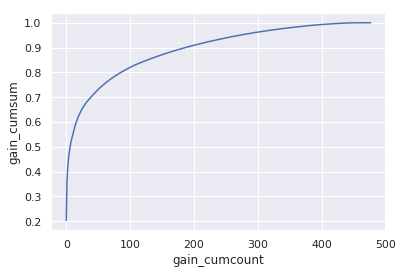

In [68]:
ax = sns.lineplot(x="gain_cumcount", y="gain_cumsum", data=feature_importance_df)

In [69]:
# plt.figure(figsize=(14,28))
# sns.barplot(x="gain", y="Feature", data=best_features[:50].sort_values(by="gain",ascending=False))
# plt.title('Features importance (averaged/folds)')
# plt.tight_layout()
# plt.savefig('FI.png')

In [70]:
top_features = sorted(feature_importance_df.loc[feature_importance_df['gain_cumsum']<=0.99,'Feature'].values)
print(len(top_features))
print(top_features)

388
['acc_Bird Measurer (Assessment)', 'acc_Cart Balancer (Assessment)', 'acc_Cauldron Filler (Assessment)', 'acc_Chest Sorter (Assessment)', 'acc_Mushroom Sorter (Assessment)', 'accumulated_accuracy', 'accumulated_accuracy_group', 'accumulated_actions', 'accumulated_correct_attempts', 'accumulated_uncorrect_attempts', 'accuracy_group_0', 'accuracy_group_1', 'accuracy_group_2', 'accuracy_group_3', 'duration_mean', 'ev_code_2000', 'ev_code_2010', 'ev_code_2020', 'ev_code_2025', 'ev_code_2030', 'ev_code_2035', 'ev_code_2040', 'ev_code_2050', 'ev_code_2060', 'ev_code_2070', 'ev_code_2075', 'ev_code_2080', 'ev_code_2081', 'ev_code_2083', 'ev_code_3010', 'ev_code_3020', 'ev_code_3021', 'ev_code_3110', 'ev_code_3120', 'ev_code_3121', 'ev_code_4010', 'ev_code_4020', 'ev_code_4021', 'ev_code_4022', 'ev_code_4025', 'ev_code_4030', 'ev_code_4031', 'ev_code_4035', 'ev_code_4040', 'ev_code_4045', 'ev_code_4050', 'ev_code_4070', 'ev_code_4080', 'ev_code_4090', 'ev_code_4095', 'ev_code_4100', 'ev_co

In [71]:
np.save('top_features.npy',np.array(top_features))

## Test Data Processing

In [72]:
model_path=''

In [73]:
# %%time
# # tranform function to get the train and test set
# reduce_test, categoricals = get_compiled_data(test, test_set=True,total=1000)
# print(reduce_test.shape)
# # print(list(reduce_test.columns))
# # call feature engineering function

In [74]:
# reduce_test, dummy_feats = preprocess(reduce_test)
# print(reduce_test.shape)

In [75]:
features = list(np.load(model_path+'features.npy'))

In [76]:
fold_feats = joblib.load('fold_feats.pkl')

In [77]:
reduce_test['installation_id'].head()

0    00abaee7
1    01242218
2    017c5718
3    01a44906
4    01bc6cb6
Name: installation_id, dtype: object

In [78]:
reduce_test[features].head()

,type_Clip,type_Activity,type_Assessment,type_Game,acc_Bird Measurer (Assessment),acc_Cart Balancer (Assessment),acc_Cauldron Filler (Assessment),acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),ev_code_2000,ev_code_2010,ev_code_2020,ev_code_2025,ev_code_2030,ev_code_2035,ev_code_2040,ev_code_2050,ev_code_2060,ev_code_2070,ev_code_2075,ev_code_2080,ev_code_2081,ev_code_2083,ev_code_3010,ev_code_3020,ev_code_3021,ev_code_3110,ev_code_3120,ev_code_3121,ev_code_4010,ev_code_4020,ev_code_4021,ev_code_4022,ev_code_4025,ev_code_4030,ev_code_4031,ev_code_4035,ev_code_4040,ev_code_4045,ev_code_4050,ev_code_4070,ev_code_4080,ev_code_4090,ev_code_4095,ev_code_4100,ev_code_4110,ev_code_4220,ev_code_4230,ev_code_4235,ev_code_5000,ev_code_5010,ev_id_0086365d,ev_id_00c73085,ev_id_022b4259,ev_id_02a42007,ev_id_0330ab6a,ev_id_0413e89d,ev_id_04df9b66,ev_id_05ad839b,ev_id_06372577,ev_id_070a5291,ev_id_08fd73f3,ev_id_08ff79ad,ev_id_0a08139c,ev_id_0d18d96c,ev_id_0d1da71f,ev_id_0db6d71d,ev_id_1325467d,ev_id_1340b8d7,ev_id_1375ccb7,ev_id_14de4c5d,ev_id_155f62a4,ev_id_1575e76c,ev_id_15a43e5b,ev_id_15ba1109,ev_id_15eb4a7d,ev_id_15f99afc,ev_id_160654fd,ev_id_16667cc5,ev_id_16dffff1,ev_id_17113b36,ev_id_19967db1,ev_id_1996c610,ev_id_1af8be29,ev_id_1bb5fbdb,ev_id_1beb320a,ev_id_1c178d24,ev_id_1cc7cfca,ev_id_1cf54632,ev_id_1f19558b,ev_id_222660ff,ev_id_2230fab4,ev_id_250513af,ev_id_25fa8af4,ev_id_262136f4,ev_id_26a5a3dd,ev_id_26fd2d99,ev_id_27253bdc,ev_id_28520915,ev_id_28a4eb9a,ev_id_28ed704e,ev_id_28f975ea,ev_id_29bdd9ba,ev_id_29f54413,ev_id_2a444e03,ev_id_2a512369,ev_id_2b058fe3,ev_id_2b9272f4,ev_id_2c4e6db0,ev_id_2dc29e21,ev_id_2dcad279,ev_id_2fb91ec1,ev_id_30614231,ev_id_30df3273,ev_id_31973d56,ev_id_3323d7e9,ev_id_33505eae,ev_id_3393b68b,ev_id_363c86c9,ev_id_363d3849,ev_id_36fa3ebe,ev_id_37937459,ev_id_37c53127,ev_id_37db1c2f,ev_id_37ee8496,ev_id_38074c54,ev_id_392e14df,ev_id_3a4be871,ev_id_3afb49e6,ev_id_3afde5dd,ev_id_3b2048ee,ev_id_3babcb9b,ev_id_3bb91ced,ev_id_3bb91dda,ev_id_3bf1cf26,ev_id_3bfd1a65,ev_id_3ccd3f02,ev_id_3d0b9317,ev_id_3d63345e,ev_id_3d8c61b0,ev_id_3dcdda7f,ev_id_3ddc79c3,ev_id_3dfd4aa4,ev_id_3edf6747,ev_id_3ee399c3,ev_id_44cb4907,ev_id_45d01abe,ev_id_461eace6,ev_id_46b50ba8,ev_id_46cd75b4,ev_id_47026d5f,ev_id_47efca07,ev_id_47f43a44,ev_id_48349b14,ev_id_4901243f,ev_id_499edb7c,ev_id_49ed92e9,ev_id_4a09ace1,ev_id_4a4c3d21,ev_id_4b5efe37,ev_id_4bb2f698,ev_id_4c2ec19f,ev_id_4d6737eb,ev_id_4d911100,ev_id_4e5fc6f5,ev_id_4ef8cdd3,ev_id_51102b85,ev_id_51311d7a,ev_id_5154fc30,ev_id_5290eab1,ev_id_532a2afb,ev_id_5348fd84,ev_id_53c6e11a,ev_id_55115cbd,ev_id_562cec5f,ev_id_565a3990,ev_id_56817e2b,ev_id_56bcd38d,ev_id_56cd3b43,ev_id_5859dfb6,ev_id_587b5989,ev_id_58a0de5c,ev_id_598f4598,ev_id_5a848010,ev_id_5b49460a,ev_id_5be391b5,ev_id_5c2f29ca,ev_id_5c3d2b2f,ev_id_5d042115,ev_id_5de79a6a,ev_id_5e109ec3,ev_id_5e3ea25a,ev_id_5e812b27,ev_id_5f0eb72c,ev_id_5f5b2617,ev_id_6043a2b4,ev_id_6077cc36,ev_id_6088b756,ev_id_63f13dd7,ev_id_65a38bf7,ev_id_65abac75,ev_id_67439901,ev_id_67aa2ada,ev_id_69fdac0a,ev_id_6aeafed4,ev_id_6bf9e3e1,ev_id_6c517a88,ev_id_6c930e6e,ev_id_6cf7d25c,ev_id_6d90d394,ev_id_6f445b57,ev_id_6f4adc4b,ev_id_6f4bd64e,ev_id_6f8106d9,ev_id_7040c096,ev_id_709b1251,ev_id_71e712d8,ev_id_71fe8f75,ev_id_731c0cbe,ev_id_736f9581,ev_id_7372e1a5,ev_id_73757a5e,ev_id_7423acbc,ev_id_74e5f8a7,ev_id_7525289a,ev_id_756e5507,ev_id_763fc34e,ev_id_76babcde,ev_id_77261ab5,ev_id_77c76bc5,ev_id_77ead60d,ev_id_792530f8,ev_id_795e4a37,ev_id_7961e599,ev_id_7ab78247,ev_id_7ad3efc6,ev_id_7cf1bc53,ev_id_7d093bf9,ev_id_7d5c30a2,ev_id_7da34a02,ev_id_7dfe6d8a,ev_id_7ec0c298,ev_id_7f0836bf,ev_id_804ee27f,ev_id_828e68f9,ev_id_832735e1,ev_id_83c6c409,ev_id_84538528,ev_id_84b0e0c8,ev_id_857f21c0,ev_id_85d1b0de,ev_id_85de926c,ev_id_86ba578b,ev_id_86c924c4,ev_id_87d743c1,ev_id_884228c8,ev_id_88d4a5be,ev_id_895865f3,ev_id_89aace00,ev_id_8ac7cce4,ev_id_8af75982,ev_id_8b757ab8,ev_id_8d748b58,ev_id_8d7e386c,ev_id_8d84fa81,ev_id_8f094001,ev_id_8fee50e2,ev_id

In [79]:
model_path=''

In [80]:
import os
for i in range(n_splits):
    filename= 'model_'+str(i)+'.pkl'
#     size= os.path.getsize(model_path+filename)
    stat= os.stat(model_path+filename)
    size= stat.st_size
    mod_time= stat.st_mtime
    print('{0} size: {1} modified time: {2}'.format(filename,size,mod_time))

model_0.pkl size: 795095 modified time: 1576432275.8715837
model_1.pkl size: 925485 modified time: 1576432275.8915856
model_2.pkl size: 957612 modified time: 1576432275.9155877
model_3.pkl size: 930908 modified time: 1576432275.9355896
model_4.pkl size: 946031 modified time: 1576432275.9595916


In [81]:
# y_pred = np.zeros((len(reduce_test), 4))
y_pred = np.zeros((reduce_test.shape[0], 1))
#load model check
for i in range(n_splits):
    model_cur = joblib.load(model_path+'model_'+str(i)+'.pkl')
    y_pred += model_cur.predict(reduce_test[features]).reshape(-1, 1) / n_splits
    
# print(y_pred[0:10])

temp = [item for sublist in y_pred for item in sublist]
pd.Series(temp).describe()

count    1000.000000
mean        1.887520
std         0.676858
min         0.002860
25%         1.471765
50%         2.066430
75%         2.407100
max         2.853664
dtype: float64

In [82]:
# # %%time
# fold_feats_test = select_features_foldwise(reduce_test,features,models1)

In [83]:
# for feats,feats_test in zip(fold_feats,fold_feats_test):
#     print(len(feats))
#     common = set(feats).intersection(set(feats_test))
#     print(len(common))

In [84]:
# shap_values_test = explainers[1].shap_values(reduce_test[features])

In [85]:
# shap.summary_plot(shap_values_test, reduce_test[features],
#                   plot_type='dot',max_display=60)

In [86]:
%%time
optR = joblib.load(model_path+'optR_fulltrain.pkl')
y_pred = np.array([item for sublist in y_pred for item in sublist])

coefficients = optR.coefficients()
print('coefficients:',coefficients)
predictions = optR.predict(y_pred, coefficients).astype(int)
pd.Series(predictions).value_counts(normalize=True)

coefficients: [1.06655655 1.61080781 2.18795741]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.35 ms


3    0.432
2    0.291
0    0.157
1    0.120
dtype: float64

In [87]:
# %%time
# sample_submission['accuracy_group'] = predictions
# sample_submission.to_csv('submission.csv', index = False)
# print(sample_submission['accuracy_group'].value_counts(normalize = True))

In [88]:
# %%time
# optR = joblib.load(model_path+'optR_oof.pkl')

# coefficients = optR.coefficients()
# print('coefficients:',coefficients)
# predictions = optR.predict(y_pred, coefficients).astype(int)
# pd.Series(predictions).value_counts(normalize=True)

In [89]:
# predictions = [item for sublist in predictions for item in sublist]
# print("Test Predicted Counts = ", Counter(np.array(predictions)))
# pd.Series(predictions).value_counts(normalize=True)